In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import json
import h5py
import os
import sys
try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
    import cv2
except:
    pass

import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, \
                            BatchNormalization, Activation, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import pickle

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import seaborn as sns


from sklearn.manifold import TSNE

Using TensorFlow backend.


# Straight Autoencoder

In [2]:
def get_autoencoder():
    input_img = Input(shape=(128, 128, 3))
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
    #encoder = Model(input_img, encoded)
    
    x = Conv2D(16, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    decoded = Activation('sigmoid')(x)
    #decoder = Model(encoded, decoded)
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

In [3]:
all_images_list_1 = []
for i in os.listdir('stuart_contrib/album_images')[:int(len(os.listdir('stuart_contrib/album_images'))/2)]:
    im = cv2.imread('stuart_contrib/album_images'+'/'+i)
    all_images_list_1.append(np.array(im)/255.)
all_images_list_1 = np.array(all_images_list_1)

print('All images in first half now imported.')
print(all_images_list_1.shape)

All images in first half now imported.
(10052, 128, 128, 3)


In [4]:
batch_size = 64
num_classes = 10
epochs = 200
x_train = all_images_list_1

autoencoder = get_autoencoder()
history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True)
print('First half of training completed.')

Epoch 1/200
10052/10052 [==============================] - 27s 3ms/step - loss: 0.5122
Epoch 2/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4811
Epoch 3/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4681
Epoch 4/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4599
Epoch 5/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4548
Epoch 6/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4510
Epoch 7/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4483
Epoch 8/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4455
Epoch 9/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4438
Epoch 10/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4426
Epoch 11/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4413
Epoch 12/200
10052/10052 [===============

10052/10052 [==============================] - 21s 2ms/step - loss: 0.4272
Epoch 95/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4273
Epoch 96/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4272
Epoch 97/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4270
Epoch 98/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4268
Epoch 99/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4270
Epoch 100/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4270
Epoch 101/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4269
Epoch 102/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4267
Epoch 103/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4271
Epoch 104/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4269
Epoch 105/200
10052/10052 [=============

10052/10052 [==============================] - 21s 2ms/step - loss: 0.4251
Epoch 187/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4250
Epoch 188/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4251
Epoch 189/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4252
Epoch 190/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4251
Epoch 191/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4250
Epoch 192/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4249
Epoch 193/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4252
Epoch 194/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4253
Epoch 195/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4250
Epoch 196/200
10052/10052 [==============================] - 21s 2ms/step - loss: 0.4251
Epoch 197/200
10052/10052 [========

In [22]:
all_images_list_1 = []
for i in os.listdir('stuart_contrib/album_images')[int(len(os.listdir('stuart_contrib/album_images'))/2):]:
    im = cv2.imread('stuart_contrib/album_images'+'/'+i)
    all_images_list_1.append(np.array(im)/255.)
all_images_list_1 = np.array(all_images_list_1)

print('All images now imported.')
print(all_images_list_1.shape)

All images now imported.
(10053, 128, 128, 3)


In [6]:
batch_size = 64
num_classes = 10
epochs = 200
x_train = all_images_list_1

autoencoder = get_autoencoder()
history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True)

Epoch 1/200
10053/10053 [==============================] - 40s 4ms/step - loss: 0.5128
Epoch 2/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4816
Epoch 3/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4690
Epoch 4/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4611
Epoch 5/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4560
Epoch 6/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4526
Epoch 7/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4500
Epoch 8/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4481
Epoch 9/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4473
Epoch 10/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4455
Epoch 11/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4447
Epoch 12/200
10053/10053 [===============

10053/10053 [==============================] - 21s 2ms/step - loss: 0.4302
Epoch 95/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4299
Epoch 96/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4298
Epoch 97/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4299
Epoch 98/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4298
Epoch 99/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4298
Epoch 100/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4299
Epoch 101/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4298
Epoch 102/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4297
Epoch 103/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4297
Epoch 104/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4299
Epoch 105/200
10053/10053 [=============

10053/10053 [==============================] - 21s 2ms/step - loss: 0.4277
Epoch 187/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4280
Epoch 188/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4278
Epoch 189/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4278
Epoch 190/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4277
Epoch 191/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4277
Epoch 192/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4284
Epoch 193/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4277
Epoch 194/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4277
Epoch 195/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4276
Epoch 196/200
10053/10053 [==============================] - 21s 2ms/step - loss: 0.4278
Epoch 197/200
10053/10053 [========

In [7]:
autoencoder.save('records_ae_v1.h5')

In [8]:
parse_autoencoder= load_model('records_ae_v1.h5')
#parse_autoencoder.summary()

parse_encoder = Model(parse_autoencoder.input, parse_autoencoder.layers[12].output)

parse_decoder_input = Input(shape=(16,16,16,))
parse_decoder = Model(parse_decoder_input, parse_autoencoder.layers[27](
                                            parse_autoencoder.layers[26](
                                            parse_autoencoder.layers[25](
                                            parse_autoencoder.layers[24](
                                            parse_autoencoder.layers[23](
                                            parse_autoencoder.layers[22](
                                            parse_autoencoder.layers[21](
                                            parse_autoencoder.layers[20](
                                            parse_autoencoder.layers[19](
                                            parse_autoencoder.layers[18](
                                            parse_autoencoder.layers[17](
                                            parse_autoencoder.layers[16](
                                            parse_autoencoder.layers[15](
                                            parse_autoencoder.layers[14](
                                            parse_autoencoder.layers[13](parse_decoder_input))))))))))))))))

parse_encoder.summary()
parse_decoder.summary()

parse_encoder.save('records_auto-enc_v1.h5')
parse_decoder.save('records_auto-dec_v1.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_8 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 32)        128       
__________

In [2]:
load_encoder = load_model('records_auto-enc_v1.h5')
load_decoder = load_model('records_auto-dec_v1.h5')
ae = load_model('records_ae_v1.h5')

/home/meschw04/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


2026 9601


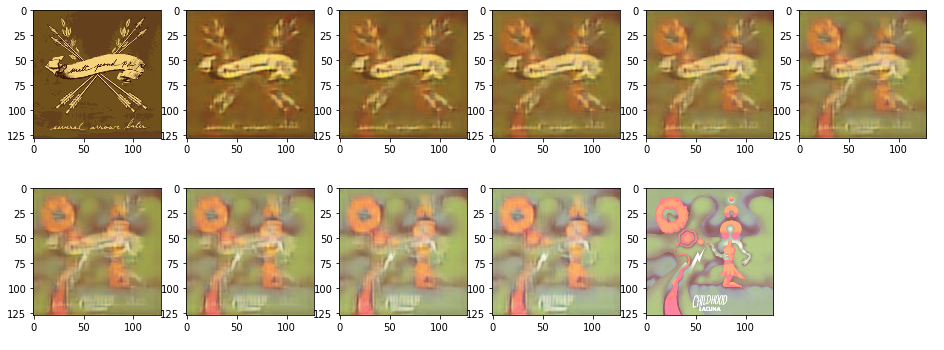

In [25]:
x_train = all_images_list_1
index1 = np.random.randint(len(x_train))
index2 = np.random.randint(len(x_train))
print(index1,index2)

#plt.figure()
#plt.imshow(cv2.cvtColor(np.uint8(x_train[index1]*255), cv2.COLOR_BGR2RGB))
#plt.show()

#plt.figure()
#plt.imshow(cv2.cvtColor(np.uint8(x_train[index2]*255), cv2.COLOR_BGR2RGB))
#plt.show()

f, axarr = plt.subplots(2, 6, figsize=(16,6))
axarr[0,0].imshow(cv2.cvtColor(np.uint8(x_train[index1]*255), cv2.COLOR_BGR2RGB))

interp_space = np.linspace(0.1,0.9,9)

test1 = load_encoder.predict(np.array([x_train[index1]]))
test2 = load_encoder.predict(np.array([x_train[index2]]))

for i in range(len(interp_space)):
    interp_01 = np.array(test1)+interp_space[i]*(np.array(test2)-np.array(test1))

    out_interp_01 = load_decoder.predict(interp_01)
    if i<5:
        axarr[0,i%5+1].imshow(cv2.cvtColor(np.uint8(out_interp_01[0]*255), cv2.COLOR_BGR2RGB))
    else:
        axarr[1,i%5].imshow(cv2.cvtColor(np.uint8(out_interp_01[0]*255), cv2.COLOR_BGR2RGB))

axarr[1,4].imshow(cv2.cvtColor(np.uint8(x_train[index2]*255), cv2.COLOR_BGR2RGB))
axarr[1,5].set_axis_off()
plt.show()

(1, 16, 16, 16)
(1, 128, 128, 3)


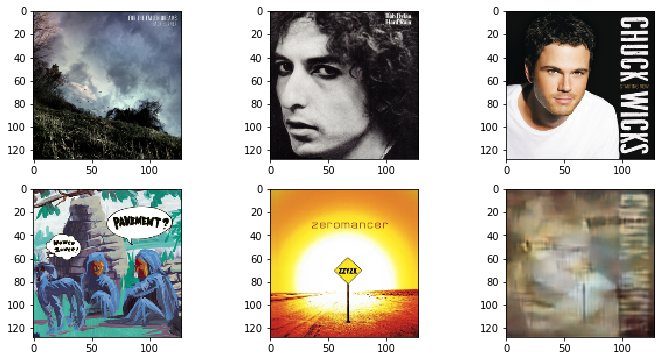

In [100]:
num_random = 5 #Odd number please!
average_pts = []

f, axarr = plt.subplots(2, int((num_random+1)/2), figsize=(12,6))
for i in range(num_random):
    index1 = np.random.randint(len(x_train))
    if i<(num_random+1)/2:
        axarr[0,i].imshow(cv2.cvtColor(np.uint8(x_train[index1]*255), cv2.COLOR_BGR2RGB))
    else:
        axarr[1,i-3].imshow(cv2.cvtColor(np.uint8(x_train[index1]*255), cv2.COLOR_BGR2RGB))
#    plt.figure()
#    plt.imshow(cv2.cvtColor(np.uint8(x_train[index1]*255), cv2.COLOR_BGR2RGB))
#    plt.show()
    test1 = load_encoder.predict(np.array([x_train[index1]]))
    average_pts.append(test1)

average_points = np.average(average_pts,axis=0)
print(average_points.shape)

out_interp_01 = load_decoder.predict(average_points)
print(out_interp_01.shape)
axarr[1,int((num_random-1)/2)].imshow(cv2.cvtColor(np.uint8(out_interp_01[0]*255), cv2.COLOR_BGR2RGB))
plt.show()

(128, 128, 3)
(10, 128, 128, 3)


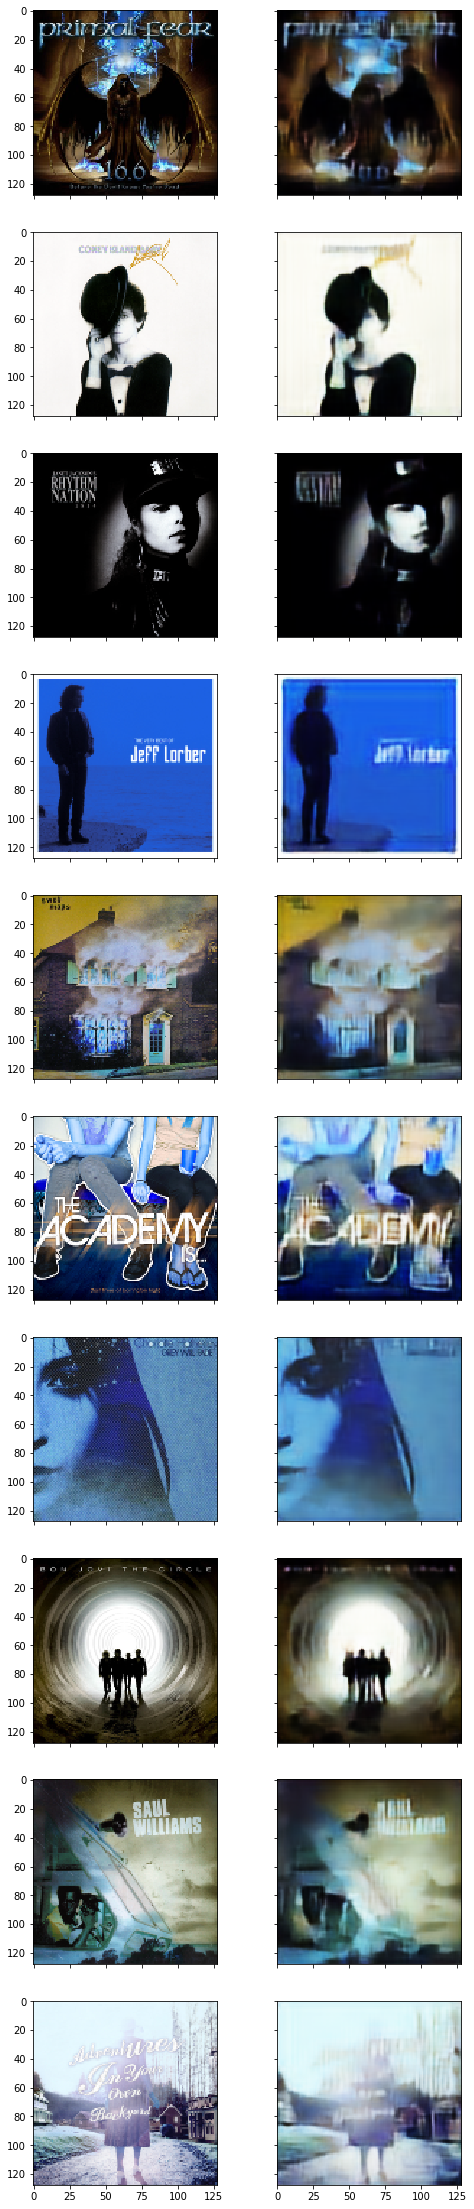

In [11]:

from skimage.io import imshow, imsave
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = 10
start_index = 5000
end_index = start_index + n_samples

pred_set = np.array([x_train[i] for i in range(start_index,start_index+n_samples)])
#pred_set = x_train[start_index:start_index+end_index,:,:,:]
out_ae = ae.predict(pred_set)

print(x_train[0].shape)
print(pred_set.shape)
fig_size = (8,40)

f, axarr = plt.subplots(end_index-start_index, 2, figsize=fig_size)
for i in range(n_samples):
    axarr[i,0].imshow(pred_set[i])
    axarr[i,1].imshow(out_ae[i])
#    axarr[i,2].imshow(out_vae[i])
    for ax in axarr.flat:
        ax.label_outer()
plt.show()

In [3]:
albums_df = pd.read_csv('albums_data.csv')
albums_df.head()

,album_name,artist,playcount,listneners,similar_albums,image_link,image_path,tags
0,$O$,Die Antwoord,5477034,206590,"[('Dungeon Family', 'Even In Darkness'), ('Bec...",https://lastfm-img2.akamaized.net/i/u/300x300/...,album_images/$O$_Die Antwoord.png,"['rap', '2010', 'Hip-Hop', 'hip hop', 'albums ..."
1,'64-'95,Lemon Jelly,1075808,84781,"[('Blue States', 'First Steps Into...'), ('Blu...",https://lastfm-img2.akamaized.net/i/u/300x300/...,album_images/'64-'95_Lemon Jelly.png,"['electronica', 'albums I own', 'chillout', 'e..."
2,'74 Jailbreak,AC/DC,1156250,174925,"[('Airbourne', 'Black Dog Barking'), ('AC/DC',...",https://lastfm-img2.akamaized.net/i/u/300x300/...,album_images/'74 Jailbreak_ACDC.png,"['hard rock', 'albums I own', 'rock', 'austral..."
3,'Round About Midnight,Miles Davis,846911,158565,"[('Miles Davis Quintet', ""Workin'""), ('Theloni...",https://lastfm-img2.akamaized.net/i/u/300x300/...,album_images/'Round About Midnight_Miles Davis...,"['jazz', 'cool jazz', 'trumpet', 'miles davis'..."
4,'Sno Angel Like You,Howe Gelb,278186,40313,"[('Golden Smog', 'Down by the Old Mainstream')...",https://lastfm-img2.akamaized.net/i/u/300x300/...,album_images/'Sno Angel Like You_Howe Gelb.png,"['albums I own', 'best of 2006', 'Alt-country'..."


In [18]:
import random
top_categories = ['rock', 'indie', 'electronic', 'pop', 'alternative',\
                  'indie rock', 'metal', 'alternative rock',\
                  'female vocalists', 'classic rock', 'folk', '80s',\
                  '90s', 'hard rock', 'Hip-Hop', 'soul', 'jazz',\
                  'experimental', 'singer-songwriter', 'ambient']

top_cats_dict = {'other':'lightgray'}
for i in top_categories:
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    top_cats_dict[i]=color

In [109]:
import ast
indie_1000 = []
rock_1000 = []
electronic_1000 = []
pop_1000 = []

for i in os.listdir('stuart_contrib/album_images'):
    t = albums_df.loc[albums_df['image_path'] == 'album_images/'+i]
    for tag in ast.literal_eval(t['tags'].tolist()[0]):
        if tag == 'pop':
            if len(pop_1000)!=1000:
                im = cv2.imread('stuart_contrib/album_images'+'/'+i)
                pop_1000.append(np.array(im)/255.)
                break
            else:
                pass
        elif tag == 'electronic':
            if len(electronic_1000)!=1000:
                im = cv2.imread('stuart_contrib/album_images'+'/'+i)
                electronic_1000.append(np.array(im)/255.)
                break
            else:
                pass
        elif tag == 'rock':
            if len(rock_1000)!=1000:
                im = cv2.imread('stuart_contrib/album_images'+'/'+i)
                rock_1000.append(np.array(im)/255.)
                break
            else:
                pass
        elif tag == 'indie':
            if len(indie_1000)!=1000:
                im = cv2.imread('stuart_contrib/album_images'+'/'+i)
                indie_1000.append(np.array(im)/255.)
                break
            else:
                pass
        else:
            pass
indie_1000 = np.array(indie_1000)
rock_1000 = np.array(rock_1000)
electronic_1000 = np.array(electronic_1000)
pop_1000 = np.array(pop_1000)
print(indie_1000.shape)
print(rock_1000.shape)
print(electronic_1000.shape)
print(pop_1000.shape)

(1000, 128, 128, 3)
(1000, 128, 128, 3)
(1000, 128, 128, 3)
(1000, 128, 128, 3)


In [110]:
comp_dict = {'indie':indie_1000,'rock':rock_1000,'electronic':electronic_1000,'pop':pop_1000}

In [120]:
combos = []
for genre1 in list(sorted(comp_dict.keys())):
    for genre2 in list(sorted(comp_dict.keys())):
        if genre1!=genre2 and genre2+'_'+genre1 not in combos:
            for i in range(1000):
                genre1_select = load_encoder.predict(np.array([comp_dict[genre1][i]]))
                genre2_select = load_encoder.predict(np.array([comp_dict[genre2][i]]))
                average_points = np.average(np.array([genre1_select,genre2_select]),axis=0)
                #print(average_points.shape)
                out_interp = load_decoder.predict(average_points)
                new_img = np.uint8(out_interp[0]*255)
                cv2.imwrite('composite_covers/'+genre1+'_'+genre2+'/'+str(i)+'.png',new_img)
#                plt.figure()
#                plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
#                plt.show()
            combos.append(genre1+'_'+genre2)


In [5]:
import ast
all_images_list_1 = []
all_playcounts_1 = []
all_tags_1 = []

for i in os.listdir('stuart_contrib/album_images')[:int(len(os.listdir('stuart_contrib/album_images'))/2)]:
    im = cv2.imread('stuart_contrib/album_images'+'/'+i)
    t = albums_df.loc[albums_df['image_path'] == 'album_images/'+i]
    all_playcounts_1.append(int(t['playcount']))
    new_cat = 'other'
    for cat in top_categories:
        if cat in ast.literal_eval(t['tags'].tolist()[0]):
            new_cat = cat
            break
        else:
            pass
    all_tags_1.append(new_cat)
    all_images_list_1.append(np.array(im)/255.)
all_images_list_1 = np.array(all_images_list_1)

print('All images now imported.')
print(all_images_list_1.shape)

All images now imported.
(10052, 128, 128, 3)


In [6]:
pca_encoded = []
for i in all_images_list_1:
    test1 = load_encoder.predict(np.array([i])).flatten()
    pca_encoded.append(test1)
del all_images_list_1

In [7]:
import ast
all_images_list_2 = []
all_playcounts_2 = []
all_tags_2 = []

for i in os.listdir('stuart_contrib/album_images')[int(len(os.listdir('stuart_contrib/album_images'))/2):]:
    im = cv2.imread('stuart_contrib/album_images'+'/'+i)
    t = albums_df.loc[albums_df['image_path'] == 'album_images/'+i]
    all_playcounts_2.append(int(t['playcount']))
    new_cat = 'other'
    for cat in top_categories:
        if cat in ast.literal_eval(t['tags'].tolist()[0]):
            new_cat = cat
            break
        else:
            pass
    all_tags_2.append(new_cat)
    all_images_list_2.append(np.array(im)/255.)
all_images_list_2 = np.array(all_images_list_2)

print('All images now imported.')
print(all_images_list_2.shape)

All images now imported.
(10053, 128, 128, 3)


In [8]:
for i in all_images_list_2:
    test1 = load_encoder.predict(np.array([i])).flatten()
    pca_encoded.append(test1)
del all_images_list_2

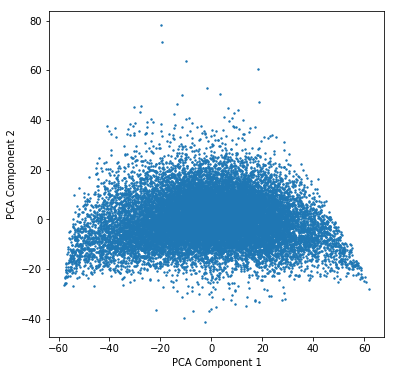

In [9]:
from sklearn.decomposition import PCA
pca_look = PCA(n_components=2)
pca_look.fit(np.array(pca_encoded))
two_d = pca_look.fit_transform(pca_encoded)

plt.figure(figsize=(6,6))
plt.scatter([i[0] for i in two_d],[i[1] for i in two_d],s=2)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

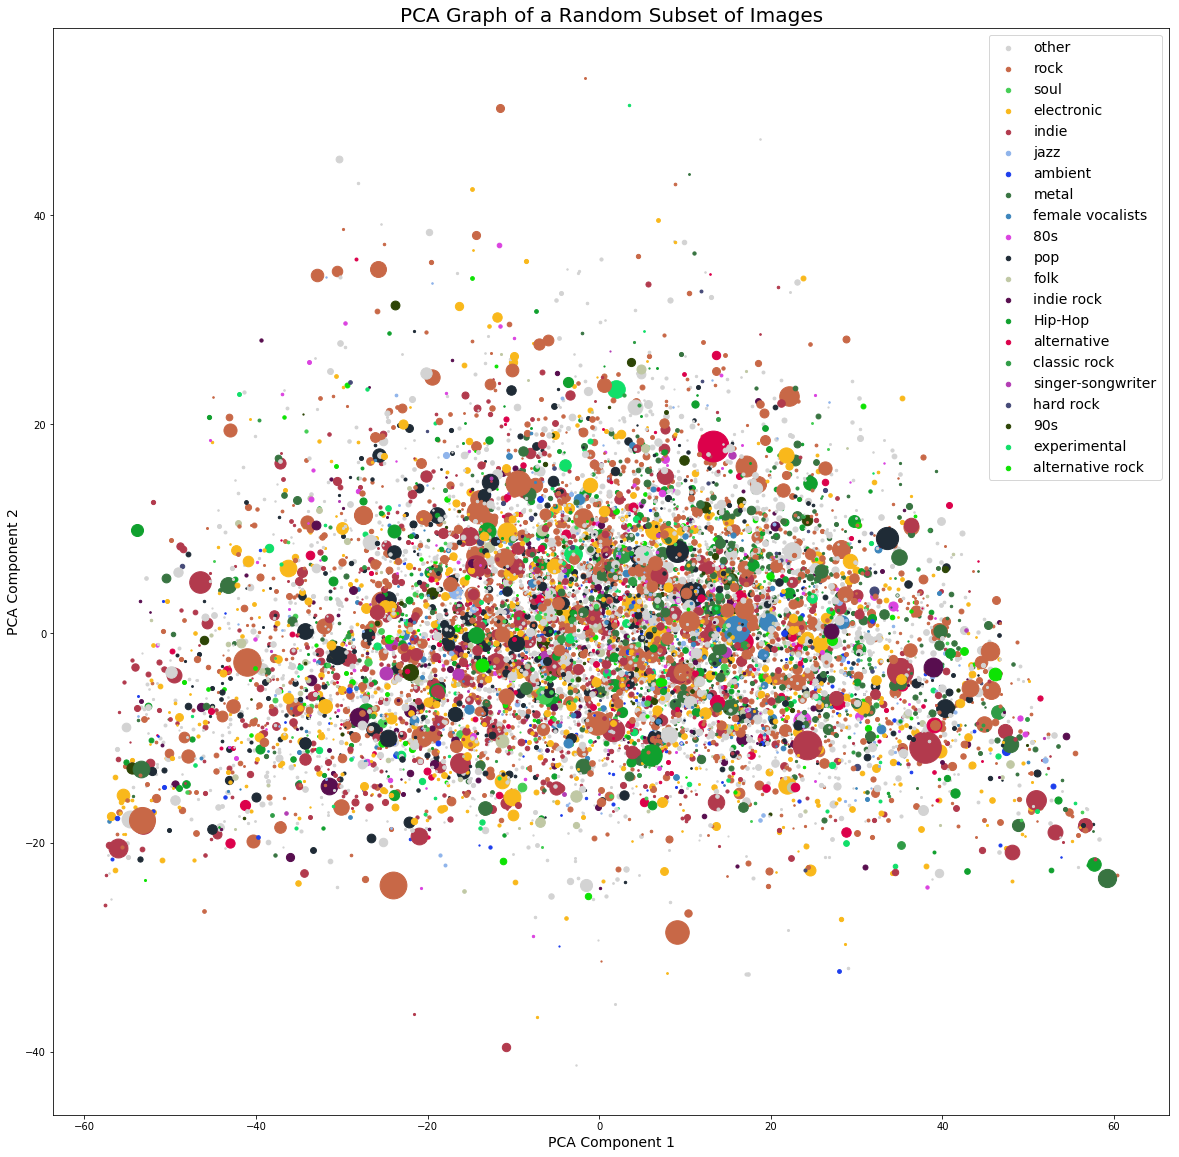

In [19]:
all_playcounts = np.array(all_playcounts_1+all_playcounts_2)
all_playcounts = all_playcounts/max(all_playcounts)
all_tags = all_tags_1+all_tags_2

all_tags_set = list(set(all_tags))


label_tags = []

plt.figure(figsize=(20,20))
for i in range(len(two_d))[:10000]:
    two_d_pt = two_d[i]
    if all_tags[i] not in label_tags:
        plt.scatter(two_d_pt[0],two_d_pt[1],\
                    s=20,\
                    c=top_cats_dict[all_tags[i]],\
                    label=all_tags[i])
        label_tags.append(all_tags[i])
    else:
        plt.scatter(two_d_pt[0],two_d_pt[1],\
                    s=all_playcounts[i]*1000,\
                    c=top_cats_dict[all_tags[i]])
plt.legend(fontsize=14)
plt.xlabel('PCA Component 1',fontsize=14)
plt.ylabel('PCA Component 2',fontsize=14)
plt.title('PCA Graph of a Random Subset of Images',fontsize=20)
plt.show()

In [20]:
full = zip(two_d, all_playcounts, all_tags)
full = sorted(full, key=lambda i: i[1])

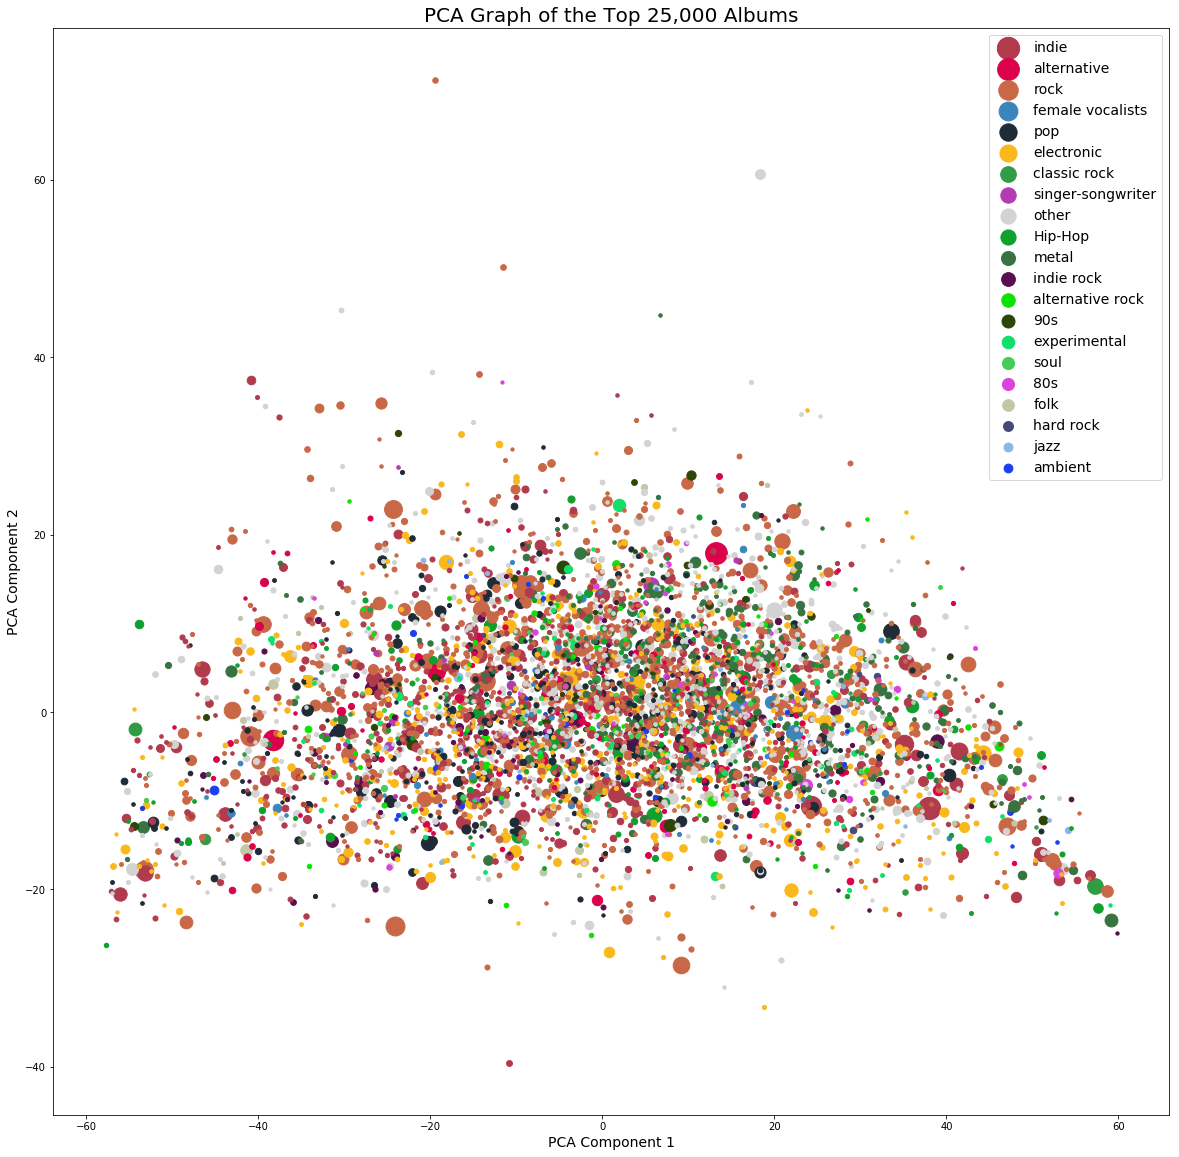

In [21]:
label_tags = []
plt.figure(figsize=(20,20))
sub_full = full[len(full)-25000:]
sub_full.reverse()
for i in sub_full:
    if i[2] not in label_tags:
        plt.scatter(i[0][0],i[0][1],\
                    s=i[1]*500,\
                    c=top_cats_dict[i[2]],\
                    label=i[2])
        label_tags.append(i[2])
    else:
        plt.scatter(i[0][0],i[0][1],\
                    s=i[1]*500,\
                    c=top_cats_dict[i[2]])
plt.legend(fontsize=14)
plt.xlabel('PCA Component 1',fontsize=14)
plt.ylabel('PCA Component 2',fontsize=14)
plt.title('PCA Graph of the Top 25,000 Albums',fontsize=20)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne_look = TSNE(n_components=2)
tsne_look.fit(np.array(pca_encoded))
tsne_2d = tsne_look.fit_transform(pca_encoded)

plt.figure(figsize=(6,6))
plt.scatter([i[0] for i in tsne_2d],[i[1] for i in tsne_2d],s=2)
plt.xlabel('tSNE Component 1')
plt.ylabel('tSNE Component 2')
plt.show()
